### Imports and constants

In [1]:
import sys
if not '../' in sys.path:
    sys.path.append('../')
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from tqdm import tqdm_notebook as tqdm

data_dir = '../data/'

### Load data

In [2]:
train_file = data_dir + 'train.csv'
test_files = glob.glob(data_dir + 'test/*')

#### Test data

In [5]:
test_df = pd.read_csv(test_files[0])
test_df.head()

,acoustic_data
0,3
1,0
2,-1
3,-2
4,2


In [10]:
for f in test_files[0:5]:
    print(len(pd.read_csv(f)))

150000
150000
150000
150000
150000


Test sequences are consistently 150,000 values long.

#### Train data

In [3]:
train_df = pd.read_csv(train_file)

In [17]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [19]:
print("There are {:,} rows in the training data.".format(len(train_df)))

There are 629,145,480 rows in the training data.


It is not obvious how to construct individual training examples (data points) from this data. Things to note:
- The test data points are all of the same, fixed length, but the training data is just one continuous sequence
- We have a label for each row in the training data
- We have a very large amount of training data, it might not be feasible to use all of it

A reasonable strategy would be to split the training data points in to sequences of the same lengths as the test data. It would perhaps not be unreasonable to use overlapping sequences, however, we have so much data that it might not even be necessary.

In [8]:
window_size = len(test_df)
window_step = 10000
print("Splitting the training data into sequences of length {:,} with step size {:,} would give us {:,} training examples.".format(
    window_size, window_step, len(train_df) // window_step - window_size//window_step))

Splitting the training data into sequences of length 150,000 with step size 10,000 would give us 62,899 training examples.


### Exploration

#### The acoustic data

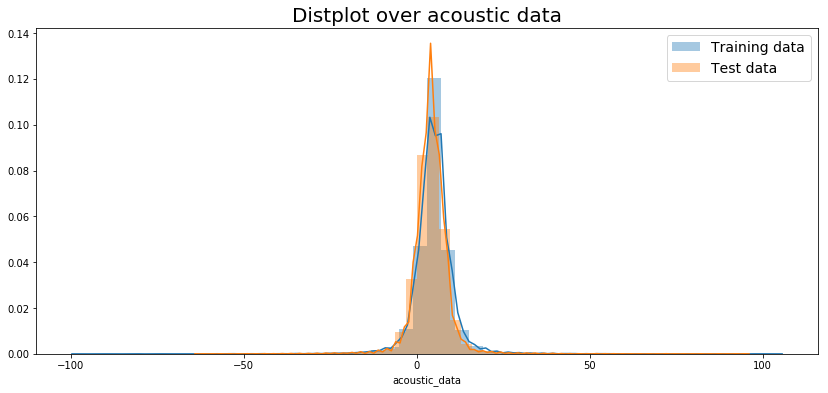

In [53]:
plt.figure(figsize=(14, 6))
sns.distplot(train_df['acoustic_data'][0:50000]);
sns.distplot(test_df['acoustic_data'][0:50000]);
plt.title('Distplot over acoustic data', fontsize=20);
plt.legend(['Training data', 'Test data'], fontsize=14);

Distributions look similar for training and test data.

In [70]:
train_desc = train_df['acoustic_data'].describe()
train_desc

count    6.291455e+08
mean     4.519468e+00
std      1.073571e+01
min     -5.515000e+03
25%      2.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      5.444000e+03
Name: acoustic_data, dtype: float64

In [59]:
test_df['acoustic_data'].describe()

count    150000.000000
mean          4.082147
std           6.559360
min        -121.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         103.000000
Name: acoustic_data, dtype: float64

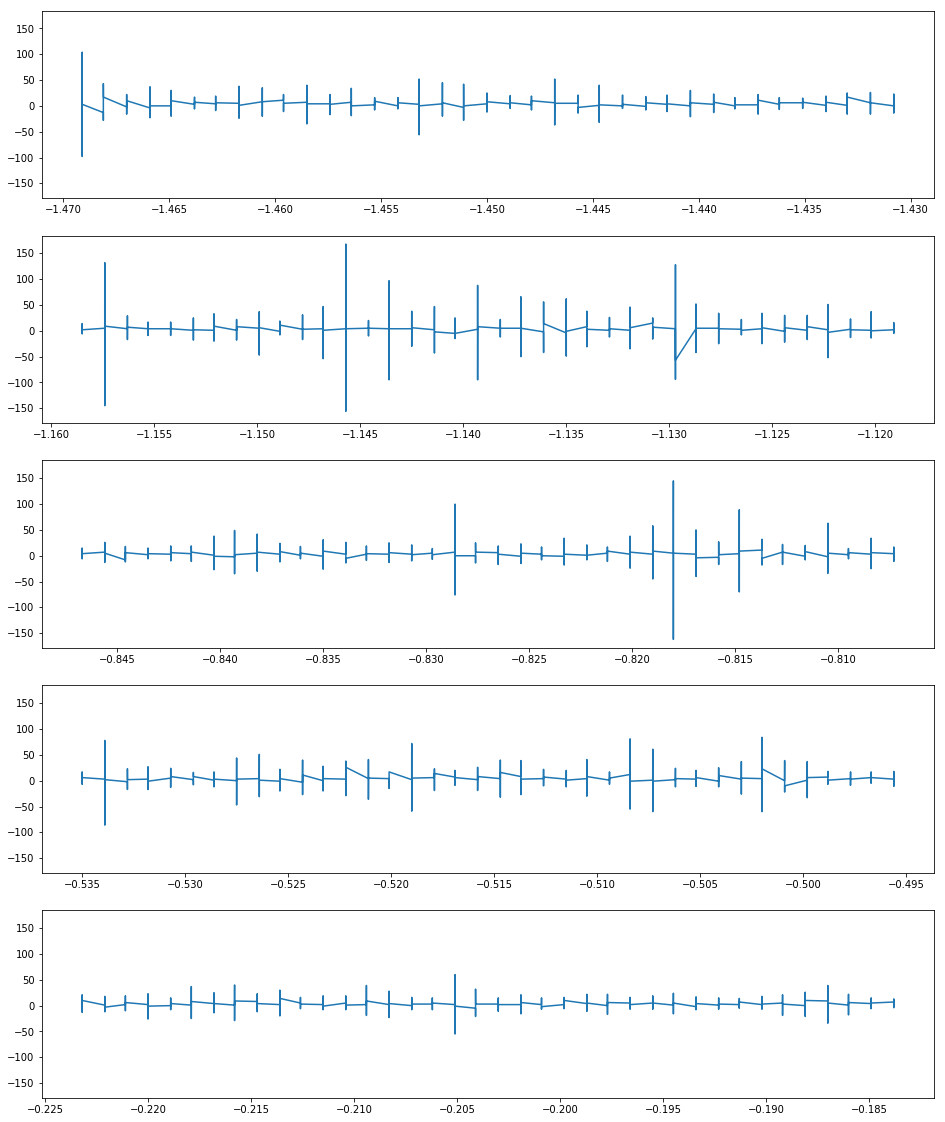

In [51]:
n = 150000
n_plots = 5
f, axes = plt.subplots(n_plots, figsize=(16, 4*n_plots), sharey=True)
for i in range(n_plots):
    step = 8
    start = i*n*step
    stop = (i*step+1)*n
    axes[i].plot(-train_df['time_to_failure'][start:stop], train_df['acoustic_data'][start:stop]);

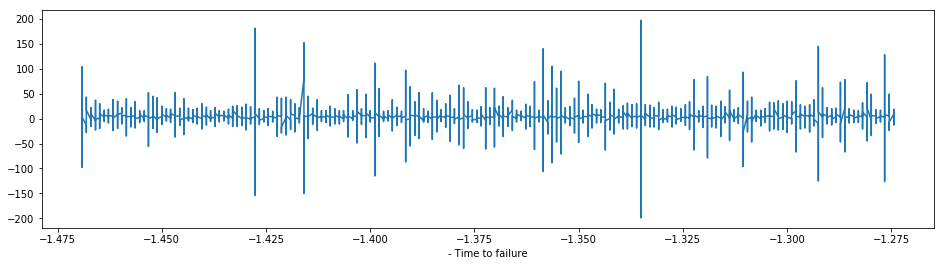

In [32]:
n = 150000*5
plt.figure(figsize=(16, 4))
plt.plot(-train_df['time_to_failure'][0:n], train_df['acoustic_data'][0:n]);
plt.xlabel('- Time to failure');

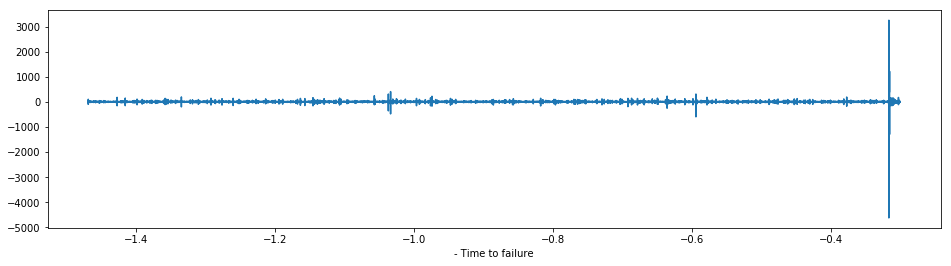

In [30]:
n = 150000*30
plt.figure(figsize=(16, 4))
plt.plot(-train_df['time_to_failure'][0:n], train_df['acoustic_data'][0:n]);
plt.xlabel('- Time to failure');

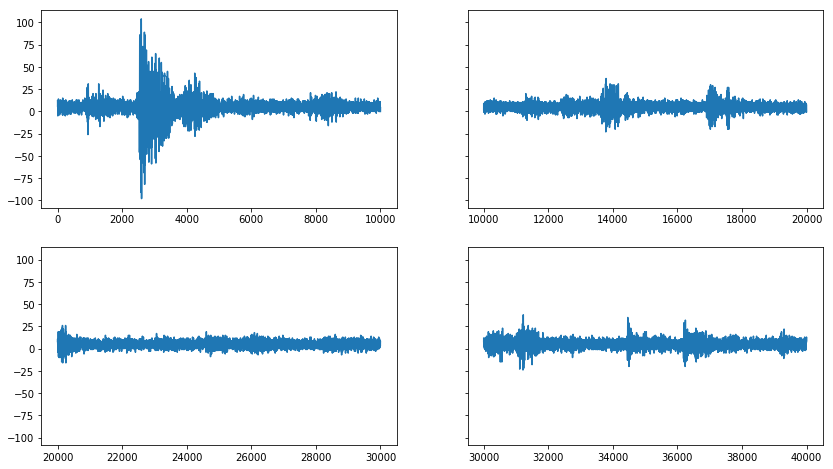

In [41]:
n = 10000
f, axes = plt.subplots(2,2, figsize=(14,8), sharey=True)
axes[0,0].plot(train_df['acoustic_data'][0:n]);
axes[0,1].plot(train_df['acoustic_data'][n:2*n]);
axes[1,0].plot(train_df['acoustic_data'][2*n:3*n]);
axes[1,1].plot(train_df['acoustic_data'][3*n:4*n]);

The acoustic_data varies strongly in amplitude. In the training data, we have peaks as high as 5000. It is not clear if the best approach is to just scale all values to fall in a range [-1, 1] or have a cut-off value for high amplitudes before scaling.

#### Time to failure

In [75]:
train_df['time_to_failure'].describe()

count    6.291455e+08
mean     5.678292e+00
std      3.672697e+00
min      9.550396e-05
25%      2.625997e+00
50%      5.349798e+00
75%      8.173396e+00
max      1.610740e+01
Name: time_to_failure, dtype: float64

The maximum time_to_failure is 16.1 seconds. It is not clear if these values need to be scaled for regression to work using an NN.

### Create training data points

In [83]:
def scale(acoustic_data):
    ## Puts values in range [-1, 1]
    acoustic_data = 2 * (acoustic_data - train_desc['mean']) / (train_desc['max'] - train_desc['min'])
    return acoustic_data

In [82]:
outdir = data_dir + 'preprocessed/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
outdir_train = outdir + 'train/'
if not os.path.exists(outdir_train):
    os.makedirs(outdir_train)
    
outdir_test = outdir + 'test/'
if not os.path.exists(outdir_test):
    os.makedirs(outdir_test)

window_size = 150000
window_step = 10000

In [78]:
train_desc.to_csv(outdir + 'training_data_description.csv')

#### Preprocess train

In [84]:
train_df['acoustic_data'] = scale(train_df['acoustic_data'])

In [85]:
train_df.to_csv(outdir + 'train_scaled.csv', index=None)

#### Preprocess test 

In [88]:
for i, f in tqdm(enumerate(test_files)):
    df = pd.read_csv(f)
    df['acoustic_data'] = scale(df['acoustic_data'])
    f_name = f.split('/')[-1]
    df.to_csv(outdir_test + f_name, index=None)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

#### Split train into multiple files

In [ ]:
n_points = len(train_df) // window_step

for i in tqdm(range(n_points)):
    start = i * window_step
    stop = start + window_size 
    slice_df = train_df[start : stop].copy()
    slice_df['acoustic_data'] = scale(slice_df['acoustic_data'])
    slice_df.to_csv(outdir_train + 'train_{}.csv'.format(i), index=None)